# Week 9 - Combining Models

Learning contents:
- Base Classifier
    - Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
    - Plot the decision boundary for least squares classifier
- Committees
    - Split the training data into M=9 equally sized, non-overlapping parts
    - Train M=9 Least Squares classifiers, one for each data split
    - Perform predictions on the whole dataset using a comitteee of classifiers and compute the accuracy
    - Plot the decision boundary for committee classifier
- Decision tree
    - Fit a DecisionTreeClassifier using scikit-learn, perform a prediction on the data, and compute the accuracy
    - Plot the decision boundary for the DecisionTreeClassifier
- AdaBoost
    - Create an AdaBoost classifier of DecisionTreeClassifiers using the scikit-learn library
    - Plot the decision boundary for the AdaBoostClassifier


In [303]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(); sns.set_palette('bright')

In [304]:
# Some plotting functions, we'll be using later


def plot_scatter(data, target, alpha=0.5, legend=True):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
def plot_mesh(X, pred_fn, n_class=2):
    plt_margin = 5
    x_min, x_max = min(X[:,0]) - plt_margin, max(X[:,0]) + plt_margin
    y_min, y_max = min(X[:,1]) - plt_margin, max(X[:,1]) + plt_margin
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.get_cmap('rainbow', n_class))

# Dataset
We'll be working with a slightly modified version of the digits data

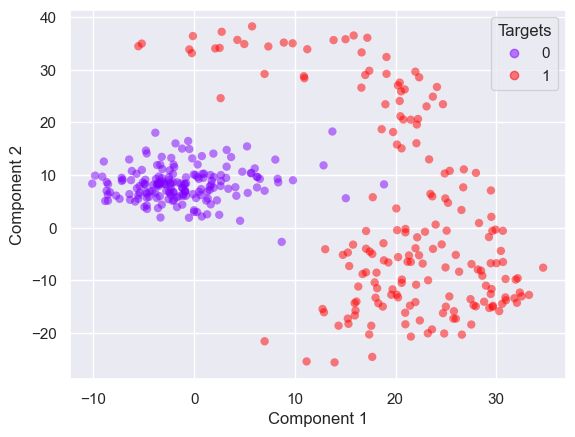

In [305]:
digits = load_digits(n_class=2)

# Get a 2D version of the data using PCA
pca = PCA(n_components=2)
t = digits.target
X = pca.fit_transform(digits.data); X[:, 1] *= -1 # Correction of the input data. 

# In order to get a non-linearly seperable case, 
# we'll modify the data a bit this time, 
# translating the '-1' class to the right and up

X = np.where(
    np.repeat(np.expand_dims(t == 1, axis=1), 2, axis=1), 
    X, 
    np.vstack([X[:,0]+20, X[:,1]+10]).T
)

N = len(t) # total number of samples

plot_scatter(X, t)

# 0) Base Classifier

## 0.1) Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
Use your solution from the exercise "Week 7 - Linear classification" section 1.1 and 1.2. The accuracy is to be calculated in terms of the proportion of correct predictions compared to the number of predictions and should print a single float.

### A. Weights

In [306]:
def optimalWeights(X, T):
    N, M = X.shape
    Xtilde = np.zeros((N, M + 1))
    Xtilde[:, 0]= 1
    Xtilde[:, 1:3] = X
    pseudoInverse = lambda A : np.linalg.inv(A.T @ A) @ (A.T)
    Wtilde = pseudoInverse(Xtilde) @ T
    return (Xtilde, Wtilde)
Xtilde, Wtilde = optimalWeights(X, t)

### B. Predictions

In [307]:
def predict(Wtilde, X): 
    N, M = X.shape
    Xtilde = np.zeros((N, M + 1))
    Xtilde[:, 0] = 1
    Xtilde[:, 1:3] = X
    
    y = Wtilde.T @ Xtilde.T
    # Upper boundary => 1, lower => 0
    boundary = np.mean(y) 
    predicts = np.array([1 if y[n] > boundary else 0 for n in range(N)])
    return predicts, boundary, y

def getAccuracy(predicts, t): 
    n = len(t)
    accuracy = np.sum(np.equal(predicts, t).astype(float))/n
    return accuracy
predicts, boundary, ym= predict(Wtilde, X)
accuracy = getAccuracy(predicts, t)
print(accuracy)


0.9444444444444444


## 0.2) Plot the decision boundary for least squares classifier
Hint: you can do this by either plotting a line on the boundary or creating a mesh of all predictions (simmilar to section 1.3 in "week 7 - Linear classification").

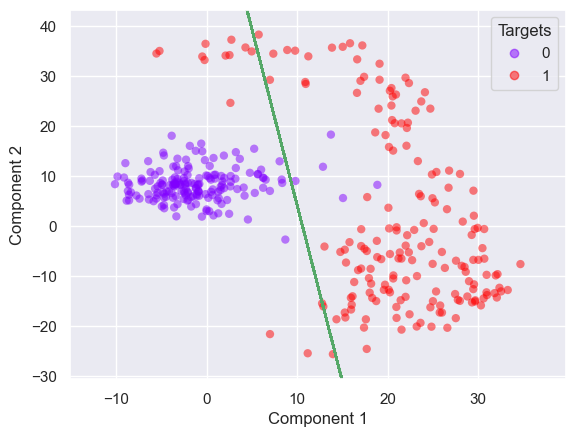

In [308]:
def plot_decision_boundary(data, weights, boundary, xlim = False, ylim = False):
    N, M = data.shape
    # yk = yj
    # yk = T 
    # The threshold is calculated as the mean of the yk classifications.
    
    # w0kx0 + w1kx1 + w2kx2 = T
    # w2kx2 = T - w0kx0 - w1kx1
    # x2 = (T - w0kx0 - w1kx1) * 1/w2k 

    x = data[:, 1] # x1 
    y = - (weights[1]/weights[2]) * x - weights[0]/weights[2] + boundary/weights[2]
    if xlim != False and ylim != False: 
        plt.xlim(xlim); plt.ylim(ylim)
    else : 
        xlim = (min(data[:, 1]) - 5, max(data[:, 1]) + 5) 
        ylim = (min(data[:, 2]) - 5, max(data[:, 2]) + 5)  
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.plot(x, y, 'g--', label='Decision Boundary')

plot_scatter(X, t)
plot_decision_boundary(Xtilde, Wtilde, boundary)

# 1) Committees

## 1.1) Split the training data into M=9 equally sized, non-overlapping parts
Hint: use the numpy.split() command.

In [309]:
M = 9
xCells = np.split(X, M)
tCells = np.split(t, M)


## 1.2) Train M=9 Least Squares classifiers, one for each (9) data split using the same method as in section 0.1
Hint: loop over the training data containing of the X split and t split zipped together using the zip() command.

In [310]:
cellAccuracy = np.array([])
boundaries = np.array([])
Weights = np.array([[]])
ym = np.array([])
for cell, target in zip(xCells, tCells): 
    Xtilde, Wtilde = optimalWeights(cell, target)
    predictions, boundary, y = predict(Wtilde, cell)
    # print(predictions)
    ym = np.append(ym, y)
    accuracy = getAccuracy(predictions, target)
    cellAccuracy = np.append(cellAccuracy, accuracy)
    boundaries = np.append(boundaries, boundary)
     #print(Wtilde)
    # print(Weights)
    Weights = np.append(Weights, Wtilde)
weights = Weights.reshape((9, 3))


print(cellAccuracy)
print(boundaries)

[1.    0.975 1.    1.    1.    1.    0.9   0.925 1.   ]
[0.475 0.525 0.475 0.525 0.525 0.5   0.525 0.475 0.525]


## 1.3) Perform a prediction on the whole dataset using committee of classifiers (lecture 17 slide 4) and compute the accuracy 

In [311]:
yCom = 1 / M * np.sum(cellAccuracy)
print(yCom)


0.9777777777777779


## 1.4 Plot the decision boundary for committee classifier

(360,)
(360,)


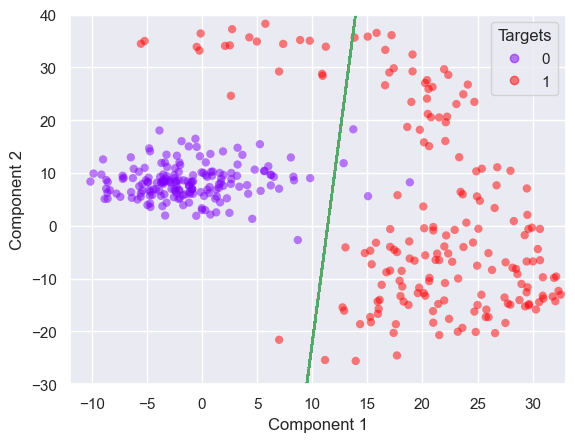

In [312]:
XtildeCells = np.shape(Xtilde)

###                                             - Disclaimer -                                                   ###
#           This code isn't a finished product, but just the last method of many, that I tried. 
# I didn't manage to get the piecewise boundary, that the answers got, but just ended up doing linear classification
#             With average weights and boundaries gotten from accross all the model fitings. 
#       It ignores more points as before, but this might be due to a better fit, ignoring the outliers? 


def plot_decision_boundary(X, weights, boundaries, xlim = False, ylim = False):
    weight = np.sum(weights, axis = 0) * 1/M 
    boundary = np.sum(boundaries) * 1/M 
    x = np.hstack(np.array([X[m][:, 0] for m in range(M)]))
    # w0x0 + w1x1 + w2x2 = B
    # (B - w0x0 - w1x1)/w2 = x2 
    
    print(x.shape)
    y = (boundary - weight[0])/weight[2] - x * weight[1]/weight[2]
    print(y.shape)
    
    if xlim != False and ylim != False: 
        plt.xlim(xlim); plt.ylim(ylim)
    else : 
        xlim = (min(x) - 5, max(x) + 5) 
        ylim = (min(cell[:, 1]) - 5, max(cell[:, 1]) + 5)  
        plt.xlim(xlim)
        plt.ylim(ylim)
    
    plt.plot(x, y, 'g--', label='Decision Boundary')
    
plot_scatter(X, t)
plot_decision_boundary(xCells, weights, boundaries, (-12, 33), (-30, 40))



# 2) Tree

## 2.1) Fit a DecisionTreeClassifier imported from the `scikit-learn` library, perform a prediction on the data, and compute the accuracy
Use `max_depth=3`. You will use fit() and predict() methods of the DecisionTreeClassifier class in order to respectively train and predict from your classifier

In [313]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model = DecisionTreeClassifier(max_depth=3)

# Splitting 
def split(n, trainingRate, X, t): 
    indices = np.random.choice(X.shape[0], int(n * trainingRate), replace=False)        # 360 * 0.8 
    x_train = X[indices]                                # trainingrate % towards training
    t_train = t[indices]
    x_test = np.delete(X, indices, axis = 0)            # testrate % towards testing
    t_test = np.delete(t, indices, axis = 0) 
    print(x_train.shape, t_train.shape)
    print(x_test.shape, t_test.shape)
    return (x_train, x_test, t_train, t_test)

x_train, x_test, t_train, t_test = split(360, 0.8, X, t)
# Fitting
model.fit(x_train, t_train)

# predicting 
y_pred = model.predict(x_test)
accuracy = getAccuracy(y_pred, t_test); print(accuracy)

(288, 2) (288,)
(72, 2) (72,)
0.9583333333333334


-- Disclaimer -- 
I don't know how the split was made during the answer. I chose to do a 20% test 80% train split, and randomly selecting them, as that should fit the model the best. 
As a consequence, my prediction differs from run to run, as the split changes. 

## 2.2) Plot the decision boundary for the DecisionTreeClassifier

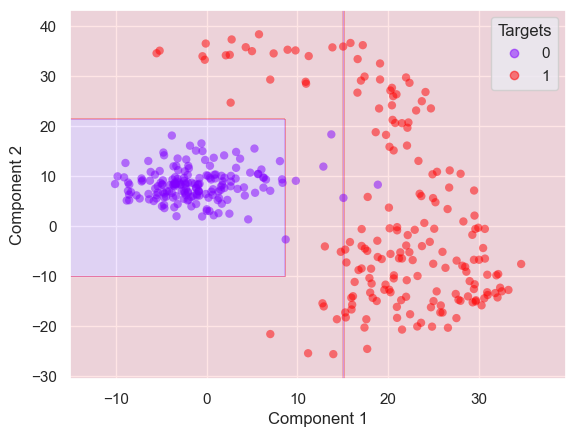

In [314]:
plot_mesh(X, model.predict, 2)
plot_scatter(X ,t)

# 3) AdaBoost

## 3.1) Create an AdaBoost classifier of DecisionTreeClassifiers using the `scikit-learn` library, and compute the accuracy
Use a depth of 1 for the `DecisionTreeClassifier` and 7 estimators for the `AdaBoostClassifier`. Use the defaults for the other parameters

In [315]:
from sklearn.ensemble import AdaBoostClassifier
model = DecisionTreeClassifier(max_depth=1)
abc = AdaBoostClassifier(estimator=model,n_estimators=7)

x_train, x_test, t_train, t_test = split(360, 0.8, X, t)
abc.fit(x_train, t_train)
y_pred = abc.predict(x_test)
accuracy = getAccuracy(y_pred, t_test)
print(accuracy)


(288, 2) (288,)
(72, 2) (72,)
1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


## 3.2) Plot the decision boundary for the AdaBoostClassifier

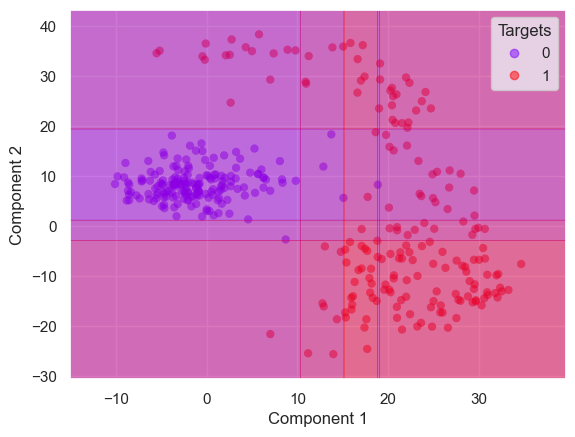

In [316]:
plot_scatter(X, t)
for estimator in abc.estimators_:
    plot_mesh(X, estimator.predict)